![../docs/images/banner-small.png](../docs/images/banner-small.png)

In [3]:
!pip install ipywidgets
from IPython.display import display, Image, clear_output
import numpy as np
import time
import cv2
import imageio_ffmpeg
import imageio
import matplotlib.pyplot as plt
import pygame
import argparse
clear_output()

In [4]:
import ipywidgets as widgets
Package_Source = widgets.ToggleButtons(
        options=['Pypi', 'Test Pypi', 'Local Repo'],
        value='Local Repo',
        description='Source:',
        disabled=False,
        button_style= 'info'
)
Package_Source

ToggleButtons(button_style='info', description='Source:', index=2, options=('Pypi', 'Test Pypi', 'Local Repo')…

In [5]:
if Package_Source.value == 'pypi':
    !pip install invertedai_simulate
    from invertedai_simulate.utils import Res, SensorSettings, Resolution, PyGameWindow, ClientSideBoundingBoxes
    from invertedai_simulate.interface import IAIEnv, ServerTimeoutError
elif Package_Source.value == 'Test Pypi':
    !pip install --extra-index-url  https://test.pypi.org/simple/ invertedai-simulate==1.0.5.dev0
    from invertedai_simulate.utils import Res, SensorSettings, Resolution, PyGameWindow, ClientSideBoundingBoxes
    from invertedai_simulate.interface import IAIEnv, ServerTimeoutError
else:
    import sys
    sys.path.append('../invertedai_simulate')
    from utils import Res, SensorSettings, Resolution, PyGameWindow, ClientSideBoundingBoxes
    from interface import IAIEnv, ServerTimeoutError    
clear_output()

In [6]:
def_res = Res.SD
scale = 1
num_cams = 2
sensors_dict = {
        f'cam_{ind}':{
            'sensor_type': 'camera',
            'camera_type': 'rgb-camera',
            'resolution': def_res,
            'radius': 20,
            'occlusion': True,
            'fov': 90.0,
            } for ind in range(num_cams)}

In [7]:
parser = argparse.ArgumentParser()
IAIEnv.add_config(parser)
config = parser.parse_args(['--client_id', 'MySimulation'])
server_ip = input('Enter server IP:')
config.zmq_server_address = f"{server_ip}:5555"
world_parameters = dict(carlatown='Town04')
scenario_parameters = dict(camera_location_variation=SensorSettings.Location(x=1, z=1, y=1),
                           camera_rotation_variation=SensorSettings.Rotation(yaw=10, pitch=10, roll=10))
env = IAIEnv(config)

Enter server IP: localhost


---------- Connecting to server ----------
Connected to prost, with ITRA-I


In [ ]:
obs = env.set_scenario('worlddataset', world_parameters=world_parameters, scenario_parameters=scenario_parameters, sensors=sensors_dict)

Output()

/home/alireza/iai/sim/develop/tests/.venv/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):


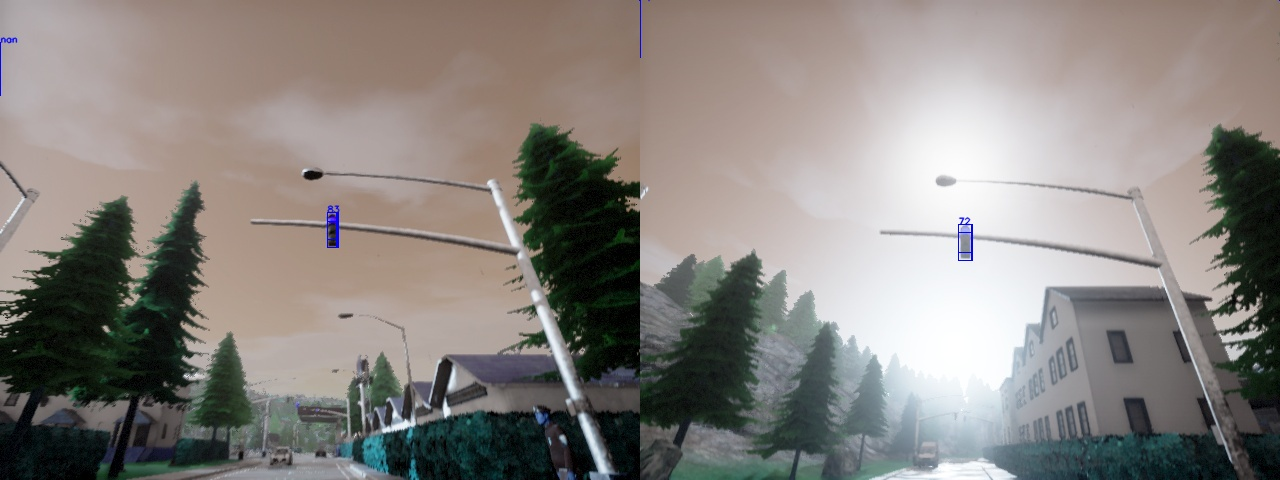

In [6]:
action = [0.0, 0.0]
obs, reward, done, info = env.step(action)
rem_self = 0
howlong = 0
frames = []
env.render_init(sensors_dict, renderer='notebook', scale=1, notebook_display=display, notebook_image=Image)

In [7]:
while not done:
    prev_action = obs['prev_action']
    if rem_self < howlong:
        action = info['expert_action']
        obs, reward, done, info = env.step(action)
        rem_self += 1
    else:
        cmd = input('Enter Steering:')
        if cmd == 'reset':
            obs = env.reset()
            jupyter_render(obs)
        elif cmd == 'init':
            obs = env.set_scenario('worlddataset', world_parameters=world_parameters, scenario_parameters=scenario_parameters, sensors=sensors_dict)
        elif cmd == 'end':
            print(env.end_simulation())
            break
        elif cmd == 'self':
            howlong = int(input('How many steps:'))
            rem_self = 0
        else:
            angle = float(cmd)
            acceleration = float(input('Enter Acceleration:'))
            action = (acceleration, angle)
            obs, reward, done, info = env.step(action)
    clear_output(wait=True)
    for attached_sensor in sensors_dict:
        name = 'boundingbox_'+attached_sensor
        if (name in obs['sensor_data']):
            bb2d = ClientSideBoundingBoxes.get_2d_bbox(obs['sensor_data'][name]['bounding_boxes'], 0, 0, sensors_dict[attached_sensor]['fov'], sensors_dict[attached_sensor]['resolution'], obs['compact_vector'][:3], obs['compact_vector'][3:6], coordinate_system='attached_sensor', occlusion=True)
            img = obs['sensor_data'][attached_sensor]['image']
            obs['sensor_data'][attached_sensor]['image'] = ClientSideBoundingBoxes.draw_bounding_boxes_on_array(img, bb2d, draw2d=False, occlusion=True)
    
    frame = env.render()
    frames.append(frame)
print(f'Episode Done, Reward:{reward}')


Enter Steering: end


Simulation Ended and Detached From Client
Episode Done, Reward:0.0


In [8]:
print(env.end_simulation())
env.close()

Simulation Ended and Detached From Client
isp (Python): zmq.REP socket disconnected from server tcp://localhost:5555


In [9]:
file_name= f'data_video.mp4'
imageio.mimwrite(file_name, frames, fps=5, quality=7)

In [10]:
from IPython.display import HTML
from base64 import b64encode

file_name= 'data_video.mp4'
mp4 = open(file_name,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1400 controls autoplay loop>
<source src="%s" type="video/mp4">
</video>
""" % data_url)